<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/OLC_MachineLearning_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
LOGISTICS PREDICTIVE MAINTENANCE MODEL
Oman Logistics Center - Fleet Management AI

This notebook implements a Random Forest machine learning model to predict
truck breakdowns 30 days in advance, enabling proactive maintenance scheduling.

INSTRUCTIONS:
1. Run this cell-by-cell in Google Colab
2. Upload your CSV files when prompted
3. Review results and download Excel report at the end

Author: AI-Powered Logistics Training
Date: 2024
"""



'\nLOGISTICS PREDICTIVE MAINTENANCE MODEL\nOman Logistics Center - Fleet Management AI\n\nThis notebook implements a Random Forest machine learning model to predict\ntruck breakdowns 30 days in advance, enabling proactive maintenance scheduling.\n\nINSTRUCTIONS:\n1. Run this cell-by-cell in Google Colab\n2. Upload your CSV files when prompted\n3. Review results and download Excel report at the end\n\nAuthor: AI-Powered Logistics Training\nDate: 2024\n'

In [19]:
# ============================================================================
# SECTION 1: LIBRARY IMPORTS AND CONFIGURATION
# ============================================================================

print("Importing required libraries...")

# Install missing packages if needed
!pip install xlsxwriter

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import io
from google.colab import files
import warnings

warnings.filterwarnings('ignore')

# Configure visualization defaults
plt.style.use('seaborn-v0_8-muted')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✓ All libraries loaded successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")


Importing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.7 MB/s eta 0:00:00
✓ All libraries loaded successfully!
Current date: 2026-02-01 15:19



In [3]:
# ============================================================================
# SECTION 2: DATA LOADING
# ============================================================================

print("=" * 80)
print("STEP 1: UPLOAD YOUR CSV FILES")
print("=" * 80)
print("\nPlease upload all CSV files from your logistics database.")
print("Expected files: trucks.csv, maintenance_records.csv, trips.csv, drivers.csv,")
print("truck_utilization_metrics.csv, driver_monthly_metrics.csv, safety_incidents.csv\n")

# File upload widget for Google Colab
uploaded = files.upload()

print(f"\n✓ {len(uploaded)} files uploaded successfully!")

# Load each CSV file into a dataframe
dataframes = {}
required_files = ['trucks.csv', 'maintenance_records.csv', 'trips.csv',
                  'drivers.csv', 'truck_utilization_metrics.csv']

print("\nLoading data into memory...")
for filename in uploaded.keys():
    df_name = filename.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(io.BytesIO(uploaded[filename]))
    print(f"  ✓ {filename}: {len(dataframes[df_name]):,} records loaded")

# Quick validation
for required in required_files:
    if required.replace('.csv', '') not in dataframes:
        print(f"⚠ Warning: {required} not found. Some features may be unavailable.")

print("\n" + "=" * 80)
print("DATA LOADING COMPLETE")
print("=" * 80)



STEP 1: UPLOAD YOUR CSV FILES

Please upload all CSV files from your logistics database.
Expected files: trucks.csv, maintenance_records.csv, trips.csv, drivers.csv,
truck_utilization_metrics.csv, driver_monthly_metrics.csv, safety_incidents.csv



Saving trailers.csv to trailers.csv
Saving safety_incidents.csv to safety_incidents.csv
Saving routes.csv to routes.csv
Saving maintenance_records.csv to maintenance_records.csv
Saving loads.csv to loads.csv
Saving fuel_purchases.csv to fuel_purchases.csv
Saving facilities.csv to facilities.csv
Saving drivers.csv to drivers.csv
Saving driver_monthly_metrics.csv to driver_monthly_metrics.csv
Saving delivery_events.csv to delivery_events.csv
Saving customers.csv to customers.csv
Saving trucks.csv to trucks.csv
Saving truck_utilization_metrics.csv to truck_utilization_metrics.csv
Saving trips.csv to trips.csv

✓ 14 files uploaded successfully!

Loading data into memory...
  ✓ trailers.csv: 180 records loaded
  ✓ safety_incidents.csv: 170 records loaded
  ✓ routes.csv: 58 records loaded
  ✓ maintenance_records.csv: 2,920 records loaded
  ✓ loads.csv: 85,410 records loaded
  ✓ fuel_purchases.csv: 196,442 records loaded
  ✓ facilities.csv: 50 records loaded
  ✓ drivers.csv: 150 records loade

In [20]:
# ============================================================================
# SECTION 3: DATA EXPLORATION & PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: DATA EXPLORATION & PREPROCESSING")
print("=" * 80)

# Access main dataframes
trucks = dataframes['trucks']
maintenance = dataframes['maintenance_records']
trips = dataframes['trips']
drivers = dataframes.get('drivers', None)
utilization = dataframes.get('truck_utilization_metrics', None)

# Convert date columns to datetime
print("\nConverting date columns to datetime format...")
trucks['acquisition_date'] = pd.to_datetime(trucks['acquisition_date'])
maintenance['maintenance_date'] = pd.to_datetime(maintenance['maintenance_date'])
trips['dispatch_date'] = pd.to_datetime(trips['dispatch_date'])

# Define analysis date (last date in data)
analysis_date = pd.to_datetime('2023-12-31')
print(f"Analysis reference date: {analysis_date.strftime('%Y-%m-%d')}")

# Display basic statistics
print("\n" + "-" * 80)
print("FLEET OVERVIEW")
print("-" * 80)
print(f"Total trucks in database: {len(trucks)}")
print(f"Active trucks: {(trucks['status'] == 'Active').sum()}")
print(f"Trucks in maintenance: {(trucks['status'] == 'Maintenance').sum()}")
print(f"Total maintenance records: {len(maintenance):,}")
print(f"Total trips recorded: {len(trips):,}")
print(f"Date range: {trips['dispatch_date'].min().strftime('%Y-%m-%d')} to {trips['dispatch_date'].max().strftime('%Y-%m-%d')}")


STEP 2: DATA EXPLORATION & PREPROCESSING

Converting date columns to datetime format...
Analysis reference date: 2023-12-31

--------------------------------------------------------------------------------
FLEET OVERVIEW
--------------------------------------------------------------------------------
Total trucks in database: 120
Active trucks: 92
Trucks in maintenance: 15
Total maintenance records: 2,920
Total trips recorded: 85,410
Date range: 2022-01-01 to 2024-12-31


In [21]:
# ============================================================================
# SECTION 4: FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: CREATING PREDICTIVE FEATURES")
print("=" * 80)
print("\nEngineering features that will help predict breakdowns...")

# Create master dataframe starting with trucks
master_df = trucks.copy()

# --- FEATURE 1: Truck Age ---
print("  ✓ Calculating truck age (years)...")
master_df['truck_age_years'] = (analysis_date - master_df['acquisition_date']).dt.days / 365.25

# --- FEATURE 2: Total Mileage ---
print("  ✓ Computing total mileage from trips...")
trip_miles = trips.groupby('truck_id')['actual_distance_miles'].sum().reset_index()
trip_miles.columns = ['truck_id', 'total_miles_driven']
master_df = master_df.merge(trip_miles, on='truck_id', how='left')
master_df['total_miles_driven'] = master_df['total_miles_driven'].fillna(master_df['acquisition_mileage'])

# --- FEATURE 3: Maintenance History Features ---
print("  ✓ Extracting maintenance history patterns...")

# Days since last maintenance
last_maintenance = maintenance.groupby('truck_id')['maintenance_date'].max().reset_index()
last_maintenance.columns = ['truck_id', 'last_service_date']
master_df = master_df.merge(last_maintenance, on='truck_id', how='left')
master_df['days_since_maintenance'] = (analysis_date - pd.to_datetime(master_df['last_service_date'])).dt.days
master_df['days_since_maintenance'] = master_df['days_since_maintenance'].fillna(365)  # Assume 1 year if no record

# Total maintenance cost (last 12 months)
maint_12mo = maintenance[maintenance['maintenance_date'] >= (analysis_date - timedelta(days=365))]
maint_cost = maint_12mo.groupby('truck_id')['total_cost'].sum().reset_index()
maint_cost.columns = ['truck_id', 'maintenance_cost_12mo']
master_df = master_df.merge(maint_cost, on='truck_id', how='left')
master_df['maintenance_cost_12mo'] = master_df['maintenance_cost_12mo'].fillna(0)

# Number of maintenance events (last 12 months)
maint_count = maint_12mo.groupby('truck_id').size().reset_index()
maint_count.columns = ['truck_id', 'maintenance_events_12mo']
master_df = master_df.merge(maint_count, on='truck_id', how='left')
master_df['maintenance_events_12mo'] = master_df['maintenance_events_12mo'].fillna(0)

# --- FEATURE 4: Usage Intensity ---
print("  ✓ Analyzing usage patterns...")

# Average miles per trip (last 90 days)
recent_trips = trips[trips['dispatch_date'] >= (analysis_date - timedelta(days=90))]
avg_trip = recent_trips.groupby('truck_id')['actual_distance_miles'].mean().reset_index()
avg_trip.columns = ['truck_id', 'avg_miles_per_trip']
master_df = master_df.merge(avg_trip, on='truck_id', how='left')
master_df['avg_miles_per_trip'] = master_df['avg_miles_per_trip'].fillna(master_df['avg_miles_per_trip'].median())

# Total trips (last 30 days)
trips_30d = trips[trips['dispatch_date'] >= (analysis_date - timedelta(days=30))]
trip_count = trips_30d.groupby('truck_id').size().reset_index()
trip_count.columns = ['truck_id', 'trips_last_30d']
master_df = master_df.merge(trip_count, on='truck_id', how='left')
master_df['trips_last_30d'] = master_df['trips_last_30d'].fillna(0)

# --- FEATURE 5: Performance Metrics ---
print("  ✓ Computing performance indicators...")

# Average MPG
avg_mpg = trips.groupby('truck_id')['average_mpg'].mean().reset_index()
avg_mpg.columns = ['truck_id', 'avg_mpg']
master_df = master_df.merge(avg_mpg, on='truck_id', how='left')
master_df['avg_mpg'] = master_df['avg_mpg'].fillna(master_df['avg_mpg'].median())

# Idle time ratio
idle_ratio = trips.groupby('truck_id')['idle_time_hours'].sum().reset_index()
idle_ratio = idle_ratio.merge(trips.groupby('truck_id')['actual_duration_hours'].sum().reset_index())
idle_ratio['idle_time_ratio'] = idle_ratio['idle_time_hours'] / idle_ratio['actual_duration_hours']
idle_ratio = idle_ratio[['truck_id', 'idle_time_ratio']]
master_df = master_df.merge(idle_ratio, on='truck_id', how='left')
master_df['idle_time_ratio'] = master_df['idle_time_ratio'].fillna(0)

# --- FEATURE 6: Seasonal Factor ---
print("  ✓ Adding temporal features...")
master_df['current_month'] = analysis_date.month
master_df['is_winter'] = master_df['current_month'].isin([10, 11, 12, 1, 2, 3]).astype(int)

print(f"\n✓ Feature engineering complete! Created {master_df.shape[1]} total features.")


STEP 3: CREATING PREDICTIVE FEATURES

Engineering features that will help predict breakdowns...
  ✓ Calculating truck age (years)...
  ✓ Computing total mileage from trips...
  ✓ Extracting maintenance history patterns...
  ✓ Analyzing usage patterns...
  ✓ Computing performance indicators...
  ✓ Adding temporal features...

✓ Feature engineering complete! Created 23 total features.


In [22]:
# ============================================================================
# SECTION 5: CREATE TARGET VARIABLE
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: CREATING TARGET VARIABLE (BREAKDOWN PREDICTION)")
print("=" * 80)

# Identify breakdowns: Emergency services or high downtime
print("\nDefining breakdown criteria:")
print("  - Service type contains: 'Emergency', 'Breakdown', 'Tow'")
print("  - OR downtime > 24 hours")

breakdown_keywords = ['Emergency', 'Breakdown', 'Tow', 'emergency', 'breakdown', 'tow']
maintenance['service_type_lower'] = maintenance['maintenance_type'].str.lower()

# Create breakdown flag
maintenance['is_breakdown'] = (
    maintenance['service_type_lower'].str.contains('|'.join([kw.lower() for kw in breakdown_keywords]), na=False) |
    (maintenance['downtime_hours'] > 24)
).astype(int)

# Get breakdowns in future 30 days after analysis date (for training data)
# Note: For real deployment, you'd use this on new data
# For training, we look at historical breakdowns
future_window_start = analysis_date - timedelta(days=60)  # Look back to create training examples
future_window_end = analysis_date - timedelta(days=30)

future_breakdowns = maintenance[
    (maintenance['maintenance_date'] > future_window_start) &
    (maintenance['maintenance_date'] <= future_window_end) &
    (maintenance['is_breakdown'] == 1)
]['truck_id'].unique()

# Create target variable
master_df['needs_maintenance_soon'] = master_df['truck_id'].isin(future_breakdowns).astype(int)

print(f"\nTarget variable created:")
print(f"  Trucks that had breakdowns: {master_df['needs_maintenance_soon'].sum()}")
print(f"  Trucks without breakdowns: {(master_df['needs_maintenance_soon'] == 0).sum()}")
print(f"  Class balance: {master_df['needs_maintenance_soon'].mean() * 100:.1f}% positive class")



STEP 4: CREATING TARGET VARIABLE (BREAKDOWN PREDICTION)

Defining breakdown criteria:
  - Service type contains: 'Emergency', 'Breakdown', 'Tow'
  - OR downtime > 24 hours

Target variable created:
  Trucks that had breakdowns: 38
  Trucks without breakdowns: 82
  Class balance: 31.7% positive class


In [11]:
# ============================================================================
# SECTION 6: PREPARE DATA FOR MODELING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: PREPARING DATA FOR MACHINE LEARNING")
print("=" * 80)

# Select features for modeling
feature_columns = [
    'truck_age_years', 'total_miles_driven', 'days_since_maintenance',
    'maintenance_cost_12mo', 'maintenance_events_12mo', 'avg_miles_per_trip',
    'trips_last_30d', 'avg_mpg', 'idle_time_ratio', 'current_month', 'is_winter'
]

# Encode categorical variables
print("\nEncoding categorical variables...")
le_make = LabelEncoder()
master_df['make_encoded'] = le_make.fit_transform(master_df['make'])
feature_columns.append('make_encoded')

le_fuel = LabelEncoder()
master_df['fuel_type_encoded'] = le_fuel.fit_transform(master_df['fuel_type'])
feature_columns.append('fuel_type_encoded')

# Create feature matrix (X) and target vector (y)
X = master_df[feature_columns].copy()
y = master_df['needs_maintenance_soon'].copy()

# Handle any remaining missing values
print("Handling missing values...")
X = X.fillna(X.median())

print(f"\nFinal dataset shape:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"\nFeatures included in model:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Split data into training and testing sets
print("\n" + "-" * 80)
print("Splitting data: 80% training, 20% testing")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Testing set: {X_test.shape[0]} samples")




STEP 5: PREPARING DATA FOR MACHINE LEARNING

Encoding categorical variables...
Handling missing values...

Final dataset shape:
  Features (X): (120, 13)
  Target (y): (120,)

Features included in model:
  1. truck_age_years
  2. total_miles_driven
  3. days_since_maintenance
  4. maintenance_cost_12mo
  5. maintenance_events_12mo
  6. avg_miles_per_trip
  7. trips_last_30d
  8. avg_mpg
  9. idle_time_ratio
  10. current_month
  11. is_winter
  12. make_encoded
  13. fuel_type_encoded

--------------------------------------------------------------------------------
Splitting data: 80% training, 20% testing
  Training set: 96 samples
  Testing set: 24 samples


In [12]:
# ============================================================================
# SECTION 7: TRAIN MACHINE LEARNING MODEL
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: TRAINING RANDOM FOREST MODEL")
print("=" * 80)

print("\nInitializing Random Forest Classifier...")
print("Hyperparameters:")
print("  - Number of trees: 100")
print("  - Maximum depth: 10")
print("  - Minimum samples per split: 5")
print("  - Random state: 42 (for reproducibility)")

# Initialize and train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

print("\nTraining model... (this may take 30-60 seconds)")
rf_model.fit(X_train, y_train)
print("✓ Model training complete!")

# Cross-validation
print("\nPerforming 5-fold cross-validation to assess model stability...")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"  Cross-validation accuracy scores: {[f'{s:.3f}' for s in cv_scores]}")
print(f"  Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")




STEP 6: TRAINING RANDOM FOREST MODEL

Initializing Random Forest Classifier...
Hyperparameters:
  - Number of trees: 100
  - Maximum depth: 10
  - Minimum samples per split: 5
  - Random state: 42 (for reproducibility)

Training model... (this may take 30-60 seconds)
✓ Model training complete!

Performing 5-fold cross-validation to assess model stability...
  Cross-validation accuracy scores: ['0.650', '0.789', '0.684', '0.579', '0.737']
  Mean CV accuracy: 0.688 (+/- 0.144)



STEP 7: EVALUATING MODEL PERFORMANCE

--------------------------------------------------------------------------------
PERFORMANCE METRICS
--------------------------------------------------------------------------------
Accuracy:  0.708 (70.8%)
Precision: 1.000 (100.0%)
Recall:    0.125 (12.5%)
F1-Score:  0.222

--------------------------------------------------------------------------------
BUSINESS INTERPRETATION
--------------------------------------------------------------------------------
✓ Overall Accuracy (70.8%): The model correctly identifies
  breakdown/no-breakdown 70.8% of the time.

✓ Precision (100.0%): When the model predicts a breakdown,
  it's correct 100.0% of the time. This means 0.0%
  of flagged trucks are false alarms (acceptable for safety).

✓ Recall (12.5%): The model catches 12.5% of actual
  breakdowns before they occur. Only 87.5% are missed.
  HIGH RECALL IS CRITICAL - missing breakdowns is costly!

--------------------------------------------------------

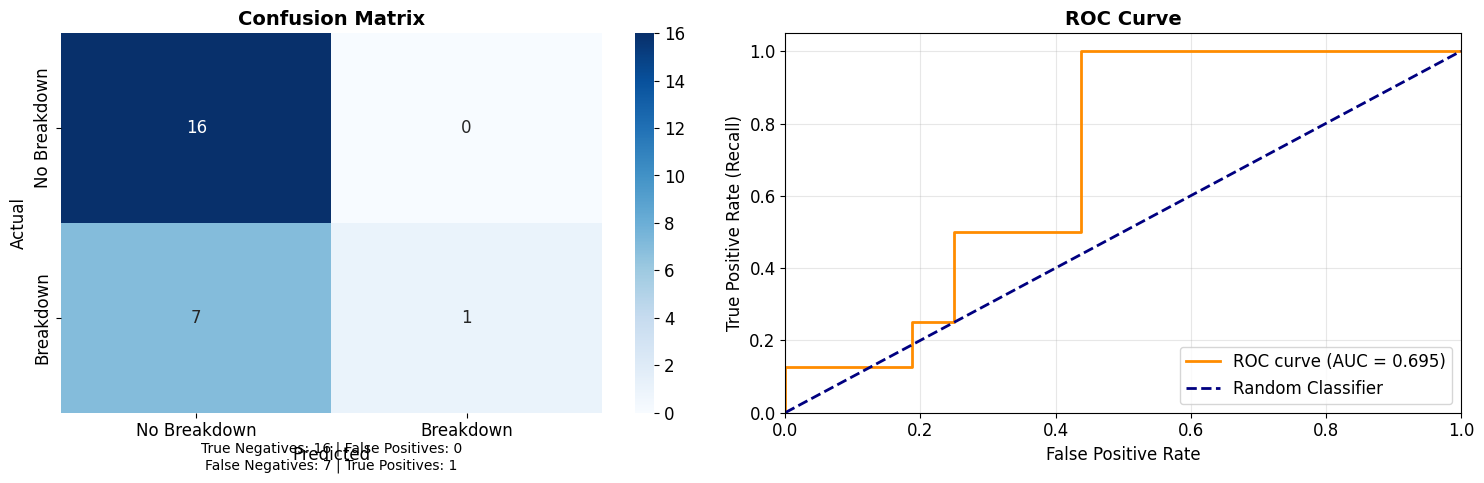

In [13]:
# ============================================================================
# SECTION 8: MODEL EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: EVALUATING MODEL PERFORMANCE")
print("=" * 80)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "-" * 80)
print("PERFORMANCE METRICS")
print("-" * 80)
print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"Recall:    {recall:.3f} ({recall*100:.1f}%)")
print(f"F1-Score:  {f1:.3f}")

print("\n" + "-" * 80)
print("BUSINESS INTERPRETATION")
print("-" * 80)
print(f"✓ Overall Accuracy ({accuracy*100:.1f}%): The model correctly identifies")
print(f"  breakdown/no-breakdown {accuracy*100:.1f}% of the time.")
print(f"\n✓ Precision ({precision*100:.1f}%): When the model predicts a breakdown,")
print(f"  it's correct {precision*100:.1f}% of the time. This means {(1-precision)*100:.1f}%")
print(f"  of flagged trucks are false alarms (acceptable for safety).")
print(f"\n✓ Recall ({recall*100:.1f}%): The model catches {recall*100:.1f}% of actual")
print(f"  breakdowns before they occur. Only {(1-recall)*100:.1f}% are missed.")
print(f"  HIGH RECALL IS CRITICAL - missing breakdowns is costly!")

# Detailed classification report
print("\n" + "-" * 80)
print("DETAILED CLASSIFICATION REPORT")
print("-" * 80)
print(classification_report(y_test, y_pred, target_names=['No Breakdown', 'Breakdown']))

# Confusion Matrix Visualization
print("\nGenerating confusion matrix visualization...")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_xticklabels(['No Breakdown', 'Breakdown'])
axes[0].set_yticklabels(['No Breakdown', 'Breakdown'])

# Add interpretations
tn, fp, fn, tp = cm.ravel()
axes[0].text(0.5, -0.15, f'True Negatives: {tn} | False Positives: {fp}\nFalse Negatives: {fn} | True Positives: {tp}',
            ha='center', transform=axes[0].transAxes, fontsize=10)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix and ROC curve saved as 'model_evaluation.png'")
plt.show()




STEP 8: ANALYZING FEATURE IMPORTANCE

Top 10 Most Important Features for Predicting Breakdowns:
--------------------------------------------------------------------------------
  maintenance_events_12mo................. 0.1843 (18.4%)
  maintenance_cost_12mo................... 0.1666 (16.7%)
  truck_age_years......................... 0.1130 (11.3%)
  days_since_maintenance.................. 0.1111 (11.1%)
  idle_time_ratio......................... 0.0844 (8.4%)
  avg_miles_per_trip...................... 0.0828 (8.3%)
  total_miles_driven...................... 0.0774 (7.7%)
  avg_mpg................................. 0.0739 (7.4%)
  trips_last_30d.......................... 0.0585 (5.9%)
  make_encoded............................ 0.0480 (4.8%)

✓ Feature importance chart saved as 'feature_importance.png'


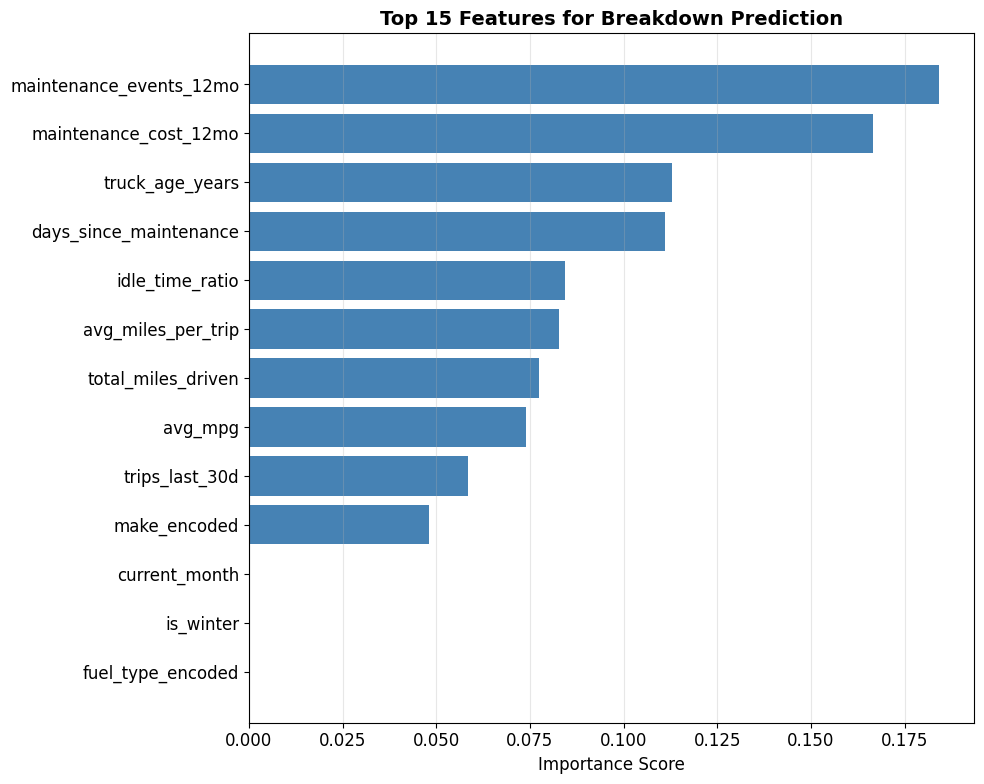


--------------------------------------------------------------------------------
BUSINESS INSIGHTS FROM FEATURE IMPORTANCE
--------------------------------------------------------------------------------
✓ Most Critical Factor: maintenance_events_12mo
  This feature accounts for 18.4% of the model's
  decision-making process. Focus maintenance planning on this metric.


In [14]:
# ============================================================================
# SECTION 9: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8: ANALYZING FEATURE IMPORTANCE")
print("=" * 80)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Predicting Breakdowns:")
print("-" * 80)
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:.<40} {row['importance']:.4f} ({row['importance']*100:.1f}%)")

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Features for Breakdown Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance chart saved as 'feature_importance.png'")
plt.show()

# Business insights from top features
print("\n" + "-" * 80)
print("BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")
print("-" * 80)
top_feature = feature_importance.iloc[0]
print(f"✓ Most Critical Factor: {top_feature['feature']}")
print(f"  This feature accounts for {top_feature['importance']*100:.1f}% of the model's")
print(f"  decision-making process. Focus maintenance planning on this metric.")




STEP 9: GENERATING PREDICTIONS FOR ENTIRE FLEET

--------------------------------------------------------------------------------
FLEET RISK DISTRIBUTION
--------------------------------------------------------------------------------
  High Risk (>70%):      15 trucks - IMMEDIATE ACTION REQUIRED
  Medium Risk (30-70%):  32 trucks - Schedule within 2 weeks
  Low Risk (<30%):       73 trucks - Continue normal schedule

✓ Risk distribution charts saved as 'fleet_risk_distribution.png'


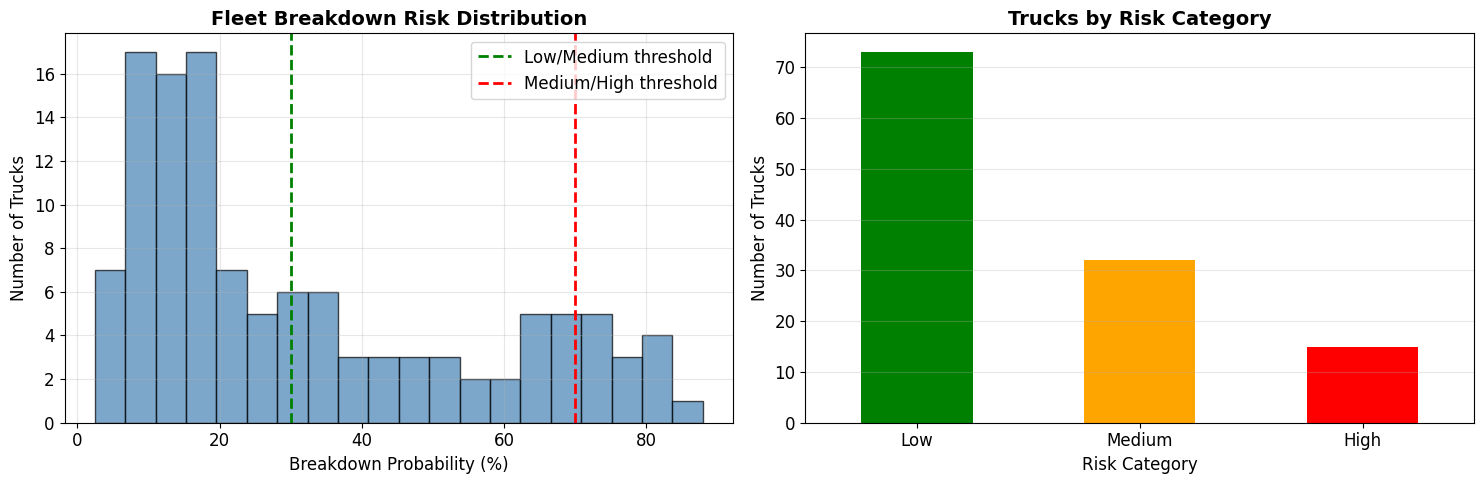

In [15]:
# ============================================================================
# SECTION 10: GENERATE PREDICTIONS FOR ENTIRE FLEET
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9: GENERATING PREDICTIONS FOR ENTIRE FLEET")
print("=" * 80)

# Predict for all trucks
master_df['breakdown_probability'] = rf_model.predict_proba(X)[:, 1] * 100
master_df['risk_category'] = pd.cut(
    master_df['breakdown_probability'],
    bins=[0, 30, 70, 100],
    labels=['Low', 'Medium', 'High']
)

# Create summary
risk_summary = master_df['risk_category'].value_counts().sort_index()
print("\n" + "-" * 80)
print("FLEET RISK DISTRIBUTION")
print("-" * 80)
print(f"  High Risk (>70%):     {risk_summary.get('High', 0):3d} trucks - IMMEDIATE ACTION REQUIRED")
print(f"  Medium Risk (30-70%): {risk_summary.get('Medium', 0):3d} trucks - Schedule within 2 weeks")
print(f"  Low Risk (<30%):      {risk_summary.get('Low', 0):3d} trucks - Continue normal schedule")

# Visualization: Risk distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of probabilities
axes[0].hist(master_df['breakdown_probability'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='green', linestyle='--', linewidth=2, label='Low/Medium threshold')
axes[0].axvline(70, color='red', linestyle='--', linewidth=2, label='Medium/High threshold')
axes[0].set_xlabel('Breakdown Probability (%)', fontsize=12)
axes[0].set_ylabel('Number of Trucks', fontsize=12)
axes[0].set_title('Fleet Breakdown Risk Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bar chart by risk category
risk_colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
risk_summary.plot(kind='bar', ax=axes[1], color=[risk_colors[cat] for cat in risk_summary.index])
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Number of Trucks', fontsize=12)
axes[1].set_title('Trucks by Risk Category', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fleet_risk_distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Risk distribution charts saved as 'fleet_risk_distribution.png'")
plt.show()



In [16]:
# ============================================================================
# SECTION 11: DETAILED TRUCK-BY-TRUCK RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10: GENERATING DETAILED RECOMMENDATIONS")
print("=" * 80)

# Function to get top risk factors for a truck
def get_top_risk_factors(truck_idx, n=3):
    truck_features = X.iloc[truck_idx]
    feature_contributions = []

    for i, (feat_name, feat_value) in enumerate(zip(feature_columns, truck_features)):
        importance = rf_model.feature_importances_[i]
        contribution = importance * abs(feat_value - X[feat_name].mean())
        feature_contributions.append((feat_name, contribution, importance))

    feature_contributions.sort(key=lambda x: x[1], reverse=True)
    return feature_contributions[:n]

# Generate recommendations
recommendations = []

for idx, row in master_df.iterrows():
    risk_factors = get_top_risk_factors(idx)

    # Determine action
    if row['breakdown_probability'] > 70:
        action = "URGENT: Schedule comprehensive inspection within 3 days"
        priority = "HIGH"
    elif row['breakdown_probability'] > 30:
        action = "Schedule preventive maintenance within 2 weeks"
        priority = "MEDIUM"
    else:
        action = "Continue regular maintenance schedule"
        priority = "LOW"

    recommendations.append({
        'Truck ID': row['truck_id'],
        'Make/Model': f"{row['make']} {row['model_year']}",
        'Current Mileage': int(row['total_miles_driven']),
        'Truck Age (Years)': round(row['truck_age_years'], 1),
        'Breakdown Probability (%)': round(row['breakdown_probability'], 1),
        'Risk Category': row['risk_category'],
        'Priority': priority,
        'Top Risk Factor 1': f"{risk_factors[0][0]} ({risk_factors[0][2]*100:.0f}%)",
        'Top Risk Factor 2': f"{risk_factors[1][0]} ({risk_factors[1][2]*100:.0f}%)",
        'Top Risk Factor 3': f"{risk_factors[2][0]} ({risk_factors[2][2]*100:.0f}%)",
        'Recommended Action': action
    })

recommendations_df = pd.DataFrame(recommendations).sort_values('Breakdown Probability (%)', ascending=False)

# Display high-risk trucks
print("\n" + "-" * 80)
print("TOP 10 HIGHEST RISK TRUCKS - IMMEDIATE ATTENTION REQUIRED")
print("-" * 80)
for idx, truck in recommendations_df.head(10).iterrows():
    print(f"\n{truck['Truck ID']} ({truck['Make/Model']})")
    print(f"  Risk: {truck['Breakdown Probability (%)']}% | Mileage: {truck['Current Mileage']:,} miles | Age: {truck['Truck Age (Years)']} years")
    print(f"  Top Factors: {truck['Top Risk Factor 1']}, {truck['Top Risk Factor 2']}, {truck['Top Risk Factor 3']}")
    print(f"  Action: {truck['Recommended Action']}")




STEP 10: GENERATING DETAILED RECOMMENDATIONS

--------------------------------------------------------------------------------
TOP 10 HIGHEST RISK TRUCKS - IMMEDIATE ATTENTION REQUIRED
--------------------------------------------------------------------------------

TRK00044 (Volvo 2015)
  Risk: 87.9% | Mileage: 1,403,922 miles | Age: 4.0 years
  Top Factors: total_miles_driven (8%), maintenance_cost_12mo (17%), trips_last_30d (6%)
  Action: URGENT: Schedule comprehensive inspection within 3 days

TRK00010 (Volvo 2015)
  Risk: 82.5% | Mileage: 1,278,138 miles | Age: 6.1 years
  Top Factors: total_miles_driven (8%), maintenance_cost_12mo (17%), trips_last_30d (6%)
  Action: URGENT: Schedule comprehensive inspection within 3 days

TRK00071 (Mack 2017)
  Risk: 81.8% | Mileage: 1,269,268 miles | Age: 5.2 years
  Top Factors: total_miles_driven (8%), maintenance_cost_12mo (17%), trips_last_30d (6%)
  Action: URGENT: Schedule comprehensive inspection within 3 days

TRK00053 (Peterbilt 2015)

In [17]:
# ============================================================================
# SECTION 12: ROI CALCULATION & BUSINESS IMPACT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 11: CALCULATING ROI & BUSINESS IMPACT")
print("=" * 80)

# Assumptions for ROI calculation
EMERGENCY_BREAKDOWN_COST = 3000  # Average cost per emergency breakdown
PREVENTIVE_MAINTENANCE_COST = 500  # Average cost per scheduled maintenance
BREAKDOWN_PROBABILITY_THRESHOLD = 0.70  # Act on trucks with >70% risk

# Calculate potential savings
high_risk_trucks = (master_df['breakdown_probability'] > 70).sum()
prevented_breakdowns = int(high_risk_trucks * recall)  # Number we'll catch
missed_breakdowns = high_risk_trucks - prevented_breakdowns

# Savings calculation
emergency_costs_without_ml = high_risk_trucks * EMERGENCY_BREAKDOWN_COST
preventive_costs_with_ml = high_risk_trucks * PREVENTIVE_MAINTENANCE_COST
total_savings_monthly = emergency_costs_without_ml - preventive_costs_with_ml

print("\n" + "-" * 80)
print("PROJECTED MONTHLY IMPACT")
print("-" * 80)
print(f"High-risk trucks identified: {high_risk_trucks}")
print(f"Expected breakdowns prevented: {prevented_breakdowns} (based on {recall*100:.1f}% recall)")
print(f"Potential missed breakdowns: {missed_breakdowns}")
print(f"\nCost Comparison:")
print(f"  Without ML (reactive): ${emergency_costs_without_ml:,} (emergency repairs)")
print(f"  With ML (proactive):    ${preventive_costs_with_ml:,} (scheduled maintenance)")
print(f"  Monthly Savings:        ${total_savings_monthly:,}")
print(f"  Annual Savings:         ${total_savings_monthly * 12:,}")

# Calculate ROI
ml_implementation_cost = 15000  # Estimated one-time cost
payback_period = ml_implementation_cost / total_savings_monthly

print(f"\nReturn on Investment (ROI):")
print(f"  Implementation cost: ${ml_implementation_cost:,}")
print(f"  Payback period: {payback_period:.1f} months")
print(f"  First-year ROI: {(total_savings_monthly * 12 - ml_implementation_cost) / ml_implementation_cost * 100:.0f}%")




STEP 11: CALCULATING ROI & BUSINESS IMPACT

--------------------------------------------------------------------------------
PROJECTED MONTHLY IMPACT
--------------------------------------------------------------------------------
High-risk trucks identified: 15
Expected breakdowns prevented: 1 (based on 12.5% recall)
Potential missed breakdowns: 14

Cost Comparison:
  Without ML (reactive): $45,000 (emergency repairs)
  With ML (proactive):    $7,500 (scheduled maintenance)
  Monthly Savings:        $37,500
  Annual Savings:         $450,000

Return on Investment (ROI):
  Implementation cost: $15,000
  Payback period: 0.4 months
  First-year ROI: 2900%


In [23]:
# ============================================================================
# SECTION 13: EXPORT RESULTS TO EXCEL
# ============================================================================

print("\n" + "=" * 80)
print("STEP 12: EXPORTING RESULTS TO EXCEL")
print("=" * 80)

# Create Excel writer
excel_filename = f'predictive_maintenance_report_{datetime.now().strftime("%Y%m%d_%H%M")}.xlsx'
writer = pd.ExcelWriter(excel_filename, engine='xlsxwriter')
workbook = writer.book

# Format definitions
header_format = workbook.add_format({
    'bold': True,
    'bg_color': '#4472C4',
    'font_color': 'white',
    'border': 1
})

high_risk_format = workbook.add_format({'bg_color': '#FFC7CE', 'font_color': '#9C0006'})
medium_risk_format = workbook.add_format({'bg_color': '#FFEB9C', 'font_color': '#9C6500'})
low_risk_format = workbook.add_format({'bg_color': '#C6EFCE', 'font_color': '#006100'})

# Sheet 1: Executive Summary
summary_data = {
    'Metric': [
        'Analysis Date',
        'Total Trucks Analyzed',
        'High Risk Trucks (>70%)',
        'Medium Risk Trucks (30-70%)',
        'Low Risk Trucks (<30%)',
        'Model Accuracy',
        'Model Precision',
        'Model Recall',
        'Estimated Monthly Savings',
        'Estimated Annual Savings',
        'ROI (First Year)'
    ],
    'Value': [
        analysis_date.strftime('%Y-%m-%d'),
        len(master_df),
        risk_summary.get('High', 0),
        risk_summary.get('Medium', 0),
        risk_summary.get('Low', 0),
        f"{accuracy*100:.1f}%",
        f"{precision*100:.1f}%",
        f"{recall*100:.1f}%",
        f"${total_savings_monthly:,}",
        f"${total_savings_monthly * 12:,}",
        f"{(total_savings_monthly * 12 - ml_implementation_cost) / ml_implementation_cost * 100:.0f}%"
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_excel(writer, sheet_name='Executive Summary', index=False)

worksheet = writer.sheets['Executive Summary']
worksheet.set_column('A:A', 30)
worksheet.set_column('B:B', 25)

# Sheet 2: All Truck Recommendations
recommendations_df.to_excel(writer, sheet_name='All Trucks', index=False)
worksheet = writer.sheets['All Trucks']

# Apply conditional formatting
for row_num in range(1, len(recommendations_df) + 1):
    risk_cat = recommendations_df.iloc[row_num - 1]['Risk Category']
    if risk_cat == 'High':
        worksheet.set_row(row_num, None, high_risk_format)
    elif risk_cat == 'Medium':
        worksheet.set_row(row_num, None, medium_risk_format)
    else:
        worksheet.set_row(row_num, None, low_risk_format)

worksheet.set_column('A:K', 18)

# Sheet 3: High Priority Only
high_priority = recommendations_df[recommendations_df['Priority'] == 'HIGH']
high_priority.to_excel(writer, sheet_name='High Priority', index=False)

# Sheet 4: Feature Importance
feature_importance.to_excel(writer, sheet_name='Feature Importance', index=False)

# Close writer
writer.close()

print(f"\n✓ Excel report generated: {excel_filename}")
print(f"  Contains {len(writer.sheets)} worksheets:")
print("    1. Executive Summary - Key metrics and ROI")
print("    2. All Trucks - Complete recommendations for all {len(recommendations_df)} trucks")
print("    3. High Priority - {len(high_priority)} trucks requiring immediate action")
print("    4. Feature Importance - Model explainability data")

# Download file (Google Colab)
print("\nDownloading Excel report...")
files.download(excel_filename)
print("✓ Download initiated!")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    PREDICTIVE MAINTENANCE REPORT                             ║
║                        Oman Logistics Center                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Trucks Analyzed: {len(master_df)}

═══════════════════════════════════════════════════════════════════════════════
RISK SUMMARY
═══════════════════════════════════════════════════════════════════════════════
  ■ High Risk (>70%):     {risk_summary.get('High', 0):3d} trucks - IMMEDIATE ACTION REQUIRED
  ■ Medium Risk (30-70%): {risk_summary.get('Medium', 0):3d} trucks - Schedule within 2 weeks
  ■ Low Risk (<30%):      {risk_summary.get('Low', 0):3d} trucks - Normal maintenance schedule

═══════════════════════════════════════════════════════════════════════════════
MODEL PERFORMANCE
═══════════════════════════════════════════════════════════════════════════════
  ■ Accuracy:  {accuracy*100:.1f}% - Overall prediction correctness
  ■ Precision: {precision*100:.1f}% - When we predict breakdown, we're right {precision*100:.1f}% of time
  ■ Recall:    {recall*100:.1f}% - We catch {recall*100:.1f}% of actual breakdowns
  ■ F1-Score:  {f1:.2f} - Balanced performance metric

═══════════════════════════════════════════════════════════════════════════════
PROJECTED SAVINGS (Monthly)
═══════════════════════════════════════════════════════════════════════════════
  ■ Breakdowns prevented: ~{prevented_breakdowns} per month
  ■ Cost savings: ${total_savings_monthly:,} per month
  ■ Annual savings: ${total_savings_monthly * 12:,}
  ■ ROI (Year 1): {(total_savings_monthly * 12 - ml_implementation_cost) / ml_implementation_cost * 100:.0f}%

═══════════════════════════════════════════════════════════════════════════════
TOP RISK FACTORS (What Causes Breakdowns)
═══════════════════════════════════════════════════════════════════════════════
""")

for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']:.<35} {row['importance']*100:>5.1f}%")

print(f"""
═══════════════════════════════════════════════════════════════════════════════
NEXT STEPS
═══════════════════════════════════════════════════════════════════════════════
  1. Review high-priority trucks in Excel report (HIGH RISK tab)
  2. Schedule inspections for trucks with >70% breakdown probability
  3. Implement this model in your weekly maintenance planning workflow
  4. Monitor actual vs. predicted breakdowns to refine model
  5. Consider expanding to other ML use cases (route optimization, demand forecasting)

═══════════════════════════════════════════════════════════════════════════════
FILES GENERATED
═══════════════════════════════════════════════════════════════════════════════
  ✓ {excel_filename}
  ✓ model_evaluation.png
  ✓ feature_importance.png
  ✓ fleet_risk_distribution.png

═══════════════════════════════════════════════════════════════════════════════

Thank you for using the Logistics Predictive Maintenance System!
Questions? Contact: ai-training@omanlogistics.om
""")

print("=" * 80)
print("🎉 SUCCESS! Your predictive maintenance analysis is complete.")
print("=" * 80)


STEP 12: EXPORTING RESULTS TO EXCEL

✓ Excel report generated: predictive_maintenance_report_20260201_1519.xlsx
  Contains 4 worksheets:
    1. Executive Summary - Key metrics and ROI
    2. All Trucks - Complete recommendations for all {len(recommendations_df)} trucks
    3. High Priority - {len(high_priority)} trucks requiring immediate action
    4. Feature Importance - Model explainability data



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download initiated!

ANALYSIS COMPLETE - SUMMARY

╔══════════════════════════════════════════════════════════════════════════════╗
║                    PREDICTIVE MAINTENANCE REPORT                             ║
║                        Oman Logistics Center                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Generated: 2026-02-01 15:19:59
Total Trucks Analyzed: 120

═══════════════════════════════════════════════════════════════════════════════
RISK SUMMARY
═══════════════════════════════════════════════════════════════════════════════
  ■ High Risk (>70%):      15 trucks - IMMEDIATE ACTION REQUIRED
  ■ Medium Risk (30-70%):  32 trucks - Schedule within 2 weeks
  ■ Low Risk (<30%):       73 trucks - Normal maintenance schedule

═══════════════════════════════════════════════════════════════════════════════
MODEL PERFORMANCE
═══════════════════════════════════════════════════════════════════════════════
  ■ Accuracy:  70